In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
# from torchmetrics.functional.image import image_gradients
import torch.optim as optim
import numpy as np
import time
import math
import pickle
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class coarseNet(nn.Module):
    def __init__(self, in_channel=3, channels=(96, 256, 384, 384, 256),
                 kernel_sizes=(11, 5, 3, 3, 3), strides=(4,1,1,1,2),
                 paddings=(0,2,1,1,0), name="coarseNet"):
        super(coarseNet, self).__init__()
        self.name = name
        self.stages = nn.ModuleList()
        self.stages.append(nn.Sequential(
            nn.Conv2d(in_channel, channels[0], kernel_sizes[0], strides[0], paddings[0]),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
        ))
        self.stages.append(nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_sizes[1], strides[1], paddings[1]),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
        ))
        for i in range(1, len(channels)-1):
            self.stages.append(nn.Sequential(
                nn.Conv2d(channels[i], channels[i+1], kernel_sizes[i+1], strides[i+1], paddings[i+1]),
                nn.ReLU(inplace=True)
            ))
        # (6*9*256 = 13824)
        self.fc1 = nn.Linear(13824, 6144)
        self.fc2 = nn.Linear(6144, 4800)
        # 4800 = 60*80
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        """
        input size: [n, H, W, C] = [n, 3, 240, 320]
        3*240*320 -> 96*29*39 -> 256*14*19 -> 384*14*19 -> 384*14*19 -> 256*6*9
        """
        for stage in self.stages:
            x = stage(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 1, 60, 80)
        return x

class fineNet(nn.Module):
    def __init__(self, name="fineNet"):
        super(fineNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 63, kernel_size = 7, stride = 2, padding=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 5, padding = 2)
        self.conv3 = nn.Conv2d(64, 1, kernel_size = 5, padding = 2)
        self.pool = nn.MaxPool2d(2)
        self.name = "fineNet"

    def forward(self, x, y):
        """
        input size: [n, H, W, C] = [n, 3, 240, 320]
        3*240*320 -> 63*120*160 -> 63*60*80 -> 64*60*80 -> 1*60*80
        """
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.cat((x,y),1)
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
def custom_loss(output, gt_depth):
    # First term: L1 loss of original images
    loss1 = nn.L1Loss()
    l_depth = loss1(output, gt_depth)
    # Second term: L2 loss(MSE)
    loss2 = nn.MSELoss()
    l_ssim = loss2(output, gt_depth)
    loss = l_ssim + l_depth
    return loss

def RMSE(output, gt_depth):
    assert output.shape == gt_depth.shape, \
        "Output and gt_depth sizes don't match!"
    diff = output - gt_depth
    diff2 = torch.pow(diff, 2)
    mse = torch.mean(diff2)
    rmse = torch.sqrt(mse)
    return rmse

def RMSE_log(output, gt_depth):
    assert output.shape == gt_depth.shape, \
        "Output and gt_depth sizes don't match!"
    output_log = torch.log(torch.clamp(output, min=1e-4, max=80.0))
    gt_depth_log = torch.log(torch.clamp(gt_depth, min=1e-4, max=80.0))
    diff_log = output_log - gt_depth_log
    rmse_log = torch.sqrt(torch.mean(torch.pow(diff_log , 2)))
    return rmse_log

def ABS_rel(output, gt_depth):
    assert output.shape == gt_depth.shape, \
        "Output and gt_depth sizes don't match!"
    output = torch.clamp(output, min=1e-4, max=80.0)
    gt_depth = torch.clamp(gt_depth, min=1e-4, max=80.0)
    diff_abs = torch.abs(output - gt_depth)
    diff_rel = diff_abs / gt_depth
    abs_rel = torch.mean(diff_rel)

    return abs_rel

def SQ_rel(output, gt_depth):
    assert output.shape == gt_depth.shape, \
        "Output and gt_depth sizes don't match!"
    output = torch.clamp(output, min=1e-4, max=80.0)
    gt_depth = torch.clamp(gt_depth, min=1e-4, max=80.0)
    diff = output - gt_depth
    sq_rel = torch.mean(torch.pow(diff, 2) / gt_depth)
    return sq_rel

def eval_threshold_acc(output, gt_depth, threeshold_val):
    assert output.shape == gt_depth.shape, \
        "Output and gt_depth sizes don't match!"
    output = torch.clamp(output, min=1e-4, max=80.0)
    gt_depth = torch.clamp(gt_depth, min=1e-4, max=80.0)
    thresh = torch.max((gt_depth / output), (output / gt_depth))

    d1 = torch.sum(thresh < threeshold_val).float() / thresh.numel()
    d2 = torch.sum(thresh < threeshold_val ** 2).float() / thresh.numel()
    d3 = torch.sum(thresh < threeshold_val ** 3).float() / thresh.numel()
    return d1, d2, d3

In [ ]:
def get_file_name(exp_name, model_name, epoch, lr, bs):
    return exp_name + '_' + model_name + '_ep' + str(epoch) + '_lr' + str(lr) + '_bs' + str(bs)

def plot_losses(path):
    import matplotlib.pyplot as plt
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    n = len(train_loss) # number of epochs
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def plot_metrics(path, metric):
    import matplotlib.pyplot as plt
    assert metric in ['rmse', 'rmse_log', 'abs_rel', 'sq_rel'], "No such metric"
    train_metric = np.loadtxt("{}_train_".format(path)+metric+".csv")
    val_metric = np.loadtxt("{}_val_".format(path)+metric+".csv")
    n = len(train_metric) # number of epochs
    plt.title("Train vs Validation: "+metric)
    plt.plot(range(1,n+1), train_metric, label="Train")
    plt.plot(range(1,n+1), val_metric, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend(loc='best')
    plt.show()


In [ ]:
def train_coarse(model, train_loader, val_loader, epoch, lr, bs, exp_name):
    root_pth = "/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/"
    model.train()
    model.cuda()
    device = torch.device('cuda')
    best_metric = 99999999
    train_coarse_loss = np.zeros(epoch)
    eval_coarse_loss = np.zeros(epoch)
    train_rmse, train_rmse_log, train_abs_rel, train_sq_rel = \
        np.zeros(epoch), np.zeros(epoch), np.zeros(epoch), np.zeros(epoch)
    eval_rmse, eval_rmse_log, eval_abs_rel, eval_sq_rel = \
        np.zeros(epoch), np.zeros(epoch), np.zeros(epoch), np.zeros(epoch)
    coarse_optimizer = optim.Adam(model.parameters(), lr = lr)
    print("Start training: ")
    start_time = time.time()
    for e in range(epoch):
        for batch_idx, data in enumerate(train_loader):
            rgb = data[0].to(device)
            depth = data[1].to(device)
            coarse_optimizer.zero_grad()
            output = model(rgb)
            depth = depth.view(-1, 1, 60, 80)

            # compute loss and metrics
            loss = custom_loss(output, depth)
            rmse = RMSE(output, depth)
            rmse_log = RMSE_log(output, depth)
            abs_rel = ABS_rel(output, depth)
            sq_rel = SQ_rel(output, depth)

            # update parameters and log metrics
            loss.backward()
            coarse_optimizer.step()
            train_coarse_loss[e] += loss.item()
            train_rmse[e] += rmse.item()
            train_rmse_log[e] += rmse_log.item()
            train_abs_rel[e] += abs_rel.item()
            train_sq_rel[e] += sq_rel.item()

        eval_loss, rmse, rmse_log, abs_rel, sq_rel = eval_coarse(model, val_loader)
        eval_coarse_loss[e] = eval_loss
        eval_rmse[e] = rmse
        eval_rmse_log[e] = rmse_log
        eval_abs_rel[e] = abs_rel
        eval_sq_rel[e] = sq_rel

        # Compute the average of metrics
        train_coarse_loss[e] /= (batch_idx+1)
        train_rmse[e] /= (batch_idx+1)
        train_rmse_log[e] /= (batch_idx+1)
        train_abs_rel[e] /= (batch_idx+1)
        train_sq_rel[e] /= (batch_idx+1)

        end_time = time.time()
        elapsed_time = end_time - start_time
        # if e==0 or (e+1)%5 == 0:
        print(f"Epoch {e+1}: Average training loss is {train_coarse_loss[e]} "
              f"Eval loss is {eval_coarse_loss[e]} "
              f"Time elapsed: {elapsed_time:.2f} seconds")
        if (rmse+rmse_log) < best_metric:
            best_metric = rmse+rmse_log
            file_name = get_file_name(exp_name, model.name, epoch, lr, bs)
            torch.save(model.state_dict(), root_pth+"pretrained_models/"+file_name+".pt")
        if (e+1)%(epoch/5) == 0 and (e+1)!=(epoch):
            file_name = get_file_name(exp_name, model.name, e+1, lr, bs)
            torch.save(model.state_dict(), root_pth+"pretrained_models/"+file_name+".pt")
    # store all metrics and losses for visualization
    file_name = get_file_name(exp_name, model.name, epoch, lr, bs)
    np.savetxt(root_pth+"logs/"+"{}_train_loss.csv".format(file_name), train_coarse_loss)
    np.savetxt(root_pth+"logs/"+"{}_val_loss.csv".format(file_name), eval_coarse_loss)
    np.savetxt(root_pth+"logs/"+"{}_train_rmse.csv".format(file_name), train_rmse)
    np.savetxt(root_pth+"logs/"+"{}_val_rmse.csv".format(file_name), eval_rmse)
    np.savetxt(root_pth+"logs/"+"{}_train_rmse_log.csv".format(file_name), train_rmse_log)
    np.savetxt(root_pth+"logs/"+"{}_val_rmse_log.csv".format(file_name), eval_rmse_log)
    np.savetxt(root_pth+"logs/"+"{}_train_abs_rel.csv".format(file_name), train_abs_rel)
    np.savetxt(root_pth+"logs/"+"{}_val_abs_rel.csv".format(file_name), eval_abs_rel)
    np.savetxt(root_pth+"logs/"+"{}_train_sq_rel.csv".format(file_name), train_sq_rel)
    np.savetxt(root_pth+"logs/"+"{}_val_sq_rel.csv".format(file_name), eval_sq_rel)

def eval_coarse(model, val_loader):
    model.eval()
    model.cuda()
    device = torch.device('cuda')
    eval_coarse_loss, eval_rmse, eval_rmse_log, eval_abs_rel, eval_sq_rel = 0,0,0,0,0
    for batch_idx, data in enumerate(val_loader):
        rgb = data[0].to(device)
        depth = data[1].to(device)
        depth = depth.view(-1, 1, 60, 80)
        output = model(rgb)

        loss = custom_loss(output, depth)
        rmse = RMSE(output, depth)
        rmse_log = RMSE_log(output, depth)
        abs_rel = ABS_rel(output, depth)
        sq_rel = SQ_rel(output, depth)

        eval_coarse_loss += loss.item()
        eval_rmse += rmse.item()
        eval_rmse_log += rmse_log.item()
        eval_abs_rel += abs_rel.item()
        eval_sq_rel += sq_rel.item()
        if batch_idx == 100:
            break

    model.train()

    eval_coarse_loss /= (batch_idx+1)
    eval_rmse /= (batch_idx+1)
    eval_rmse_log /= (batch_idx+1)
    eval_abs_rel /= (batch_idx+1)
    eval_sq_rel /= (batch_idx+1)

    return eval_coarse_loss, eval_rmse, eval_rmse_log, eval_abs_rel, eval_sq_rel

In [ ]:
# Load TensorDataset
with open("/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/data/depth_estimation_train.pkl", "rb") as f:
    train_set = pickle.load(f)

In [ ]:
with open('/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/data/depth_estimation_train9.pkl', 'rb') as f:
    val_set = pickle.load(f)

In [ ]:
with open('/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/data/depth_estimation_train10.pkl', 'rb') as f:
    test_set = pickle.load(f)

In [ ]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

6000
1000
1000


In [ ]:
# img = train_set[0][0]
# dep_map = train_set[0][1]

# img_np = img.numpy()
# img_np = np.transpose(img_np, (1, 2, 0))
# dep_map_np = dep_map.numpy()
# print(img_np.shape)
# print(dep_map_np.shape)

# plt.imshow(img_np)

In [ ]:
# plt.imshow(dep_map_np)

In [ ]:
train_loader = DataLoader(dataset=train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=8, shuffle=True)

In [ ]:
# single_batch = next(iter(train_loader))
# print(single_batch[0].shape)
# print(single_batch[1].shape)
# print(single_batch[0].dtype)
# print(single_batch[1].dtype)

In [ ]:
coarse_net = coarseNet()
coarse_net.cuda()

train_coarse(coarse_net, train_loader, val_loader, epoch=150, lr=0.0001, bs=8, exp_name="Aug3")

Start training: 
Epoch 1: Average training loss is 1.6632518546581267 Eval loss is 3.321210671179365 Time elapsed: 18.07 seconds
Epoch 2: Average training loss is 1.4525772960186005 Eval loss is 4.307986342080749 Time elapsed: 37.60 seconds
Epoch 3: Average training loss is 1.3584235404332479 Eval loss is 3.3907861308296128 Time elapsed: 55.56 seconds
Epoch 4: Average training loss is 1.2649359636306763 Eval loss is 3.368479373431442 Time elapsed: 75.20 seconds
Epoch 5: Average training loss is 1.1731425904035568 Eval loss is 4.0461105415136505 Time elapsed: 93.13 seconds
Epoch 6: Average training loss is 1.087536919116974 Eval loss is 3.1994985401040257 Time elapsed: 111.02 seconds
Epoch 7: Average training loss is 1.0188923809528352 Eval loss is 3.6894031597836183 Time elapsed: 130.46 seconds
Epoch 8: Average training loss is 0.944673609495163 Eval loss is 3.7394255966243177 Time elapsed: 148.37 seconds
Epoch 9: Average training loss is 0.8636466563940048 Eval loss is 3.8324385185052

KeyboardInterrupt: ignored

In [ ]:
# coarse_net = coarseNet()
# coarse_net.cuda()
# pretrained_coarseNet_path = '/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/pretrained_models/Aug2_coarseNet_ep100_lr0.0001_bs8.pt'
# coarse_net.load_state_dict(torch.load(pretrained_coarseNet_path))

<All keys matched successfully>

In [ ]:
root_path = "/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/"
file_name = get_file_name("Aug2", coarse_net.name, 150, 0.0001, 8)
print(file_name)
plot_losses(root_path + "logs/" + file_name)
plot_metrics(root_path + "logs/" + file_name, 'rmse')
plot_metrics(root_path + "logs/" + file_name, 'rmse_log')
plot_metrics(root_path + "logs/" + file_name, 'abs_rel')
plot_metrics(root_path + "logs/" + file_name, 'sq_rel')

Batch original shapes: torch.Size([8, 3, 240, 320]), torch.Size([8, 60, 80])
Model input: torch.Size([1, 3, 240, 320]), Model output: torch.Size([1, 1, 60, 80])gt_depth: torch.Size([60, 80])


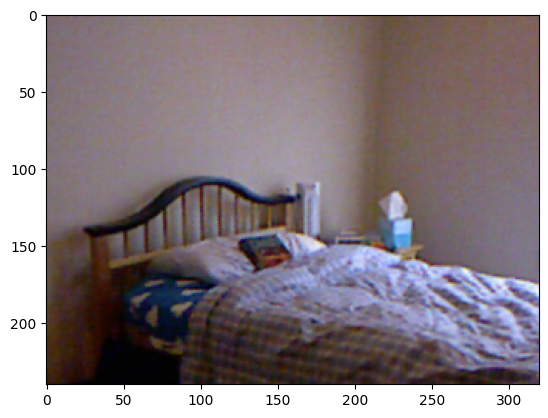

In [ ]:
test_single_batch = next(iter(test_loader))
print(f"Batch original shapes: {test_single_batch[0].shape}, {test_single_batch[1].shape}")

input_img = test_single_batch[0][6,:,:,:].unsqueeze(0)
gt_depth_map = test_single_batch[1][6,:,:]

coarse_output_depth = coarse_net(input_img.cuda())
print(f"Model input: {input_img.shape}, Model output: {coarse_output_depth.shape}"
      f"gt_depth: {gt_depth_map.shape}")

input_img = input_img.squeeze()
input_img = np.transpose(input_img, (1,2,0))

output_depth = coarse_output_depth.squeeze()
output_depth = output_depth.cpu().detach().numpy()

plt.imshow(input_img)

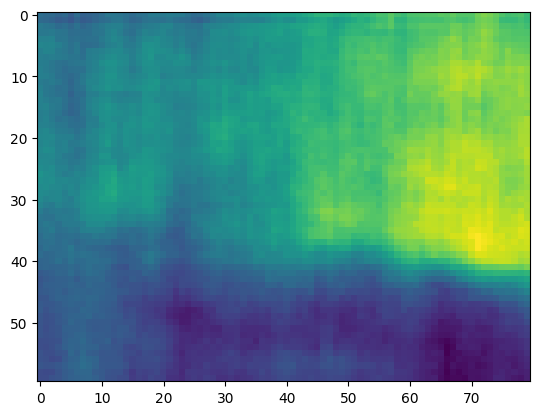

In [ ]:
plt.imshow(output_depth)

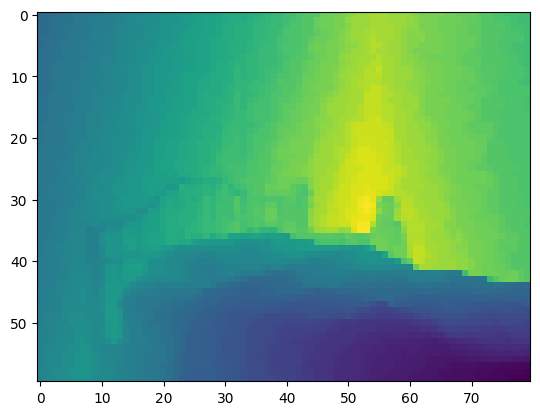

In [ ]:
plt.imshow(gt_depth_map)

In [ ]:
def test_coarse(model, test_loader):
    model.eval()
    model.cuda()
    device = torch.device('cuda')
    eval_fine_loss, eval_rmse, eval_rmse_log, eval_abs_rel, eval_sq_rel = 0,0,0,0,0
    eval_d1, eval_d2, eval_d3 = 0,0,0
    for batch_idx, data in enumerate(test_loader):
        rgb = data[0].to(device)
        depth = data[1].to(device)
        depth = depth.view(-1, 1, 60, 80)
        output = model(rgb)

        loss = custom_loss(output, depth)
        rmse = RMSE(output, depth)
        rmse_log = RMSE_log(output, depth)
        abs_rel = ABS_rel(output, depth)
        sq_rel = SQ_rel(output, depth)
        d1, d2, d3 = eval_threshold_acc(output, depth, 1.25)


        eval_fine_loss += loss.item()
        eval_rmse += rmse.item()
        eval_rmse_log += rmse_log.item()
        eval_abs_rel += abs_rel.item()
        eval_sq_rel += sq_rel.item()
        eval_d1 += d1
        eval_d2 += d2
        eval_d3 += d3

    model.train()
    eval_fine_loss /= (batch_idx+1)
    eval_rmse /= (batch_idx+1)
    eval_rmse_log /= (batch_idx+1)
    eval_abs_rel /= (batch_idx+1)
    eval_sq_rel /= (batch_idx+1)
    eval_d1 /= (batch_idx+1)
    eval_d2 /= (batch_idx+1)
    eval_d3 /= (batch_idx+1)

    return eval_fine_loss, eval_rmse, eval_rmse_log, eval_abs_rel, eval_sq_rel, eval_d1, eval_d2, eval_d3

In [ ]:
eval_fine_loss, eval_rmse, eval_rmse_log, eval_abs_rel, eval_sq_rel, eval_d1, eval_d2, eval_d3 = test_coarse(coarse_net, test_loader)

In [ ]:
print(f"RMSE: {eval_rmse:.2f}, RMSE_log: {eval_rmse_log:.2f}, abs_rel: {eval_abs_rel:.2f}, "
      f"sq_rel: {eval_sq_rel:.2f}, d1: {eval_d1:.3f}, d2: {eval_d2:.3f}, d3: {eval_d3:.3f}")

RMSE: 1.09, RMSE_log: 0.54, abs_rel: 36.98, sq_rel: 80.66, d1: 0.357, d2: 0.712, d3: 0.922


Aug2_coarseNet_ep100_lr0.0001_bs8


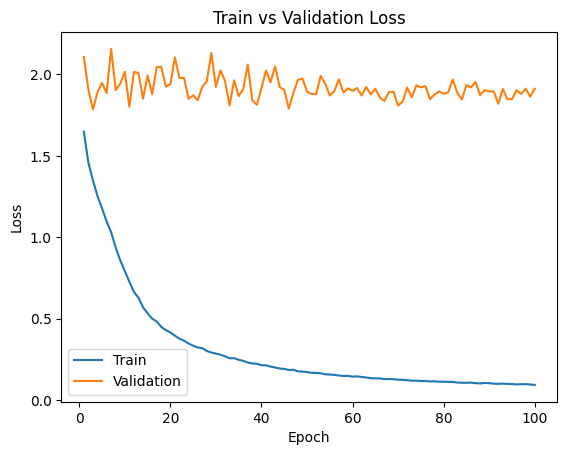

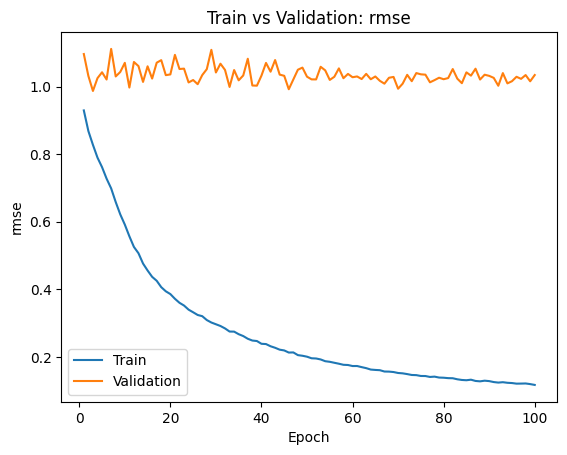

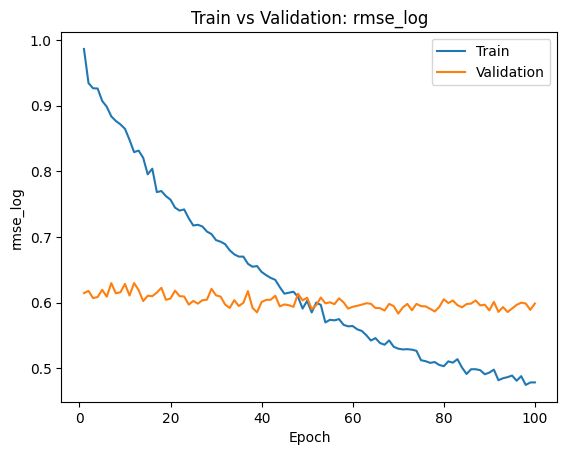

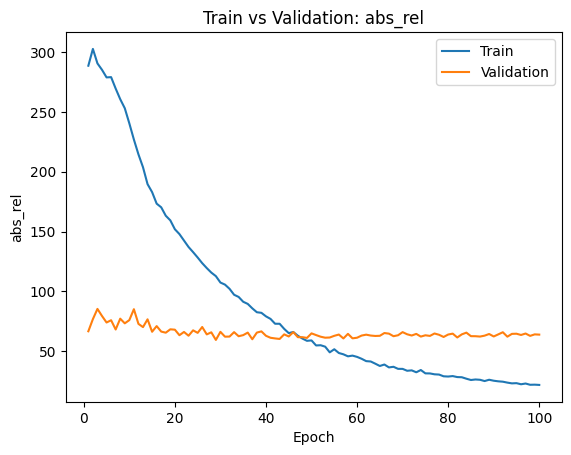

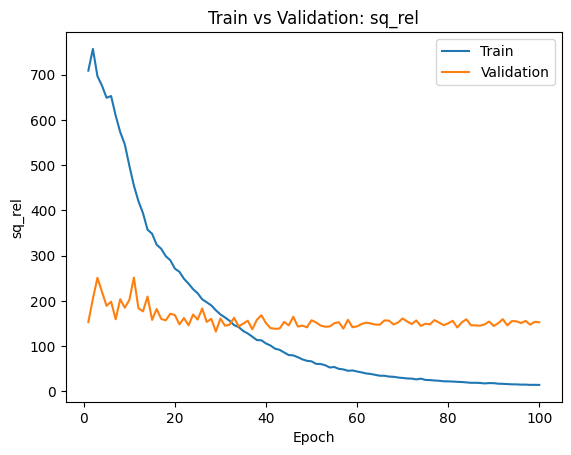

In [ ]:
root_path = "/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/"
file_name = get_file_name("Aug2", coarse_net.name, 100, 0.0001, 8)
print(file_name)
plot_losses(root_path + "logs/" + file_name)
plot_metrics(root_path + "logs/" + file_name, 'rmse')
plot_metrics(root_path + "logs/" + file_name, 'rmse_log')
plot_metrics(root_path + "logs/" + file_name, 'abs_rel')
plot_metrics(root_path + "logs/" + file_name, 'sq_rel')